In [4]:
# Q.liu
# GLCM analysis 
# 26/09.2017
import numpy as np
import cv2
import os
import time
import sys
import scipy.signal
import matplotlib.pyplot as plt

gray image size:  (256, 256)


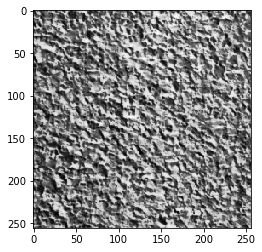

In [7]:
image_path = './output/subimg-mosaic1-1.png'

img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
print('gray image size: ',img.shape)
plt.imshow(img,'gray')
plt.show()


In [18]:
# define glcm window size : min_row = 0, max_row = 2 * win_oder, min_col = 0, max_col = max_row
# window shape = (2*win_oder+1) x (2*win_oder+1)

win_order = 2 # default 2, just for test and debug
win_shape = (2*win_order+1, 2*win_order+1) # window shape - 5 x 5
boundary_fill = 'constant' # or 'mirror'
fill_val = 0

win_img = np.zeros(win_shape)

print('Define glcm window shape: 5x5','\n',win_img)

Define glcm window shape: 5x5 
 [[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


In [31]:
img_row, img_col = img.shape # in this case, img_row = img_col = 256

img_i = 0 # row index in the image 
img_j = 0 # col index in the image

# win_i = img_i - win_order, win_j = img_j - win_oder

if boundary_fill is 'constant':  # or 'mirror'
    for row_offset in range (-1 * win_order, win_order+1):        
        for col_offset in range (-1 * win_oder, win_order+1):            
            if (img_i + row_offset) < 0 or (img_j + col_offset) < 0:
                win_img[win_order + row_offset, win_order + col_offset] = fill_val
            else:
                win_img[win_order + row_offset, win_order + col_offset] = img[img_i + row_offset, img_j + col_offset]
else: # mirror
    for row_offset in range (-1 * win_oder, win_order+1):        
        for col_offset in range (-1 * win_oder, win_order+1): 
            win_img[win_order + row_offset, win_order + col_offset] = img[abs(img_i + row_offset), abs(img_j + col_offset)]


print('sliding and copy window image on the image \n', win_img)


sliding and copy window image on the image 
 [[   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.   48.   76.  149.]
 [   0.    0.   49.   28.   55.]
 [   0.    0.   76.   35.   29.]]


In [76]:
# wrap above code as a general function

def glcm_window_img(gray_image, neighbor=2, current_row=0, current_col=0, fill='constant'):
    """
    Get an glcm window image given defined neghbourhood or window size on the original image with
    specific pixel location index

    :param gray_image: input gray level image
    :param neighbor: window order - size defined by neighborhood
    :param current_row: give current location of pixel - row index
    :param current_col: give current location of pixel - column index
    :param fill: boundary filling flag, now only have 2 types, constant or mirror
    :return: window image
    """
    max_row, max_col = gray_image.shape
    win_shape = (2 * neighbor + 1, 2 * neighbor + 1)  # window shape - 5 x 5
    win_img = np.zeros(win_shape)

    for row_offset in range(-1 * neighbor, neighbor + 1):
        for col_offset in range(-1 * neighbor, neighbor + 1):
            cp_i = current_row + row_offset
            cp_j = current_col + col_offset
            if 0 <= cp_i < max_row and 0 <= cp_j < max_col:
                win_img[neighbor + row_offset, neighbor + col_offset] = gray_image[cp_i, cp_j]
            else:
                if fill is 'constant':
                    win_img[neighbor + row_offset, neighbor + col_offset] = 0
                elif fill is 'mirror':
                    if cp_i >= max_row: 
                        cp_i = max_row - row_offset
                    if cp_j >= max_col: 
                        cp_j = max_col - col_offset
                    if cp_i < 0: 
                        cp_i = -1 - cp_i
                    if cp_j < 0: 
                        cp_j = -1 - cp_j

                    win_img[neighbor + row_offset, neighbor + col_offset] = gray_image[cp_i, cp_j]

    return win_img


In [87]:
win_img = glcm_window_img(img, 2, 0, 0,'constant')
print(win_img)

[[   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.   48.   76.  149.]
 [   0.    0.   49.   28.   55.]
 [   0.    0.   76.   35.   29.]]


In [89]:
# calculate time 
start_time = time.time()
win_img2 = glcm_window_img(img, 2, 0, 255,'constant')
print('runtime: ',time.time()-start_time)

runtime:  0.00015974044799804688


In [100]:
# Compute GLCM matrix with requantization 
grey_levels = np.unique(win_img)
level_lst = list(grey_levels)

print('grey levels of input window image: \n',level_lst[1])

num_levels = len(grey_levels) 
glcm = np.zeros([num_levels, num_levels]) # initialize a glcm matrix based on input a window image

print('initial glcm matrix: \n', glcm)

grey levels of input window image: 
 28.0
initial glcm matrix: 
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [110]:
# requantize image before GLCM
level_space = np.linspace(0,255, 8)
M, N = win_img.shape
out_img = np.zeros([M, N], dtype='uint8')
for i in range(M):
    for j in range(N):
        out_img[i,j] = min(level_space,key=lambda x: abs(x - win_img[i,j]))
    
print(out_img)
grey_levels = np.unique(out_img)
level_lst = list(grey_levels)

print('grey levels of input window image after requantization with level-8: \n',level_lst)

num_levels = len(grey_levels) 
glcm = np.zeros([num_levels, num_levels]) # initialize a glcm matrix based on input a window image
print('initial glcm matrix: \n', glcm)

[[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0  36  72 145]
 [  0   0  36  36  72]
 [  0   0  72  36  36]]
grey levels of input window image: 
 [0, 36, 72, 145]
initial glcm matrix: 
 [[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [112]:
# wrap out a general requantize function
def requantize(image, level_num=8):
    """
    Perform requantization on input gray image
    :param img: Gray image or 2-D array
    :param level_num:
    :return: 2-D image
    """
    M, N = image.shape
    level_space = np.linspace(0,255,level_num)
    out_img = np.zeros([M,N],dtype='uint8')
    for i in range(M):
        for j in range(N):
            out_img[i,j] = min(level_space,key=lambda x: abs(x-image[i,j]))

    return out_img.astype('uint8')

print('window image before requantize by level=8: \n', win_img)
win_img_req = requantize(win_img, 8)
print('window image after requantized by level=8: \n', win_img_req)


window image before requantize by level=8: 
 [[   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.   48.   76.  149.]
 [   0.    0.   49.   28.   55.]
 [   0.    0.   76.   35.   29.]]
window image after requantized by level=8: 
 [[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0  36  72 145]
 [  0   0  36  36  72]
 [  0   0  72  36  36]]


In [113]:
# 
# basic (1-order statistic) texture features for gray-level images.

def basic_info(image):
    """
    Perform some basic (1-order statistic) texture features for gray-level images.
    :param image: 2-D gray-level image
    :return: info_list, some basic features
    """
    info_list = {'min': 0, 'max': 0,
                 'mean': 0, 'std_dev': 0,
                 'skewness': 0, 'kurtosis': 0,
                 'entropy': 0, 'energy': 0,
                 'smoothness': 0, 'coefficient': 0}
    #hist, - = np.histogram(image.flatten(), bins=256, range=[0, 255], density=False)

    info_list['min'] = image.min()
    info_list['max'] = image.max()

    #hist = cv2.calcHist(image,[0],None,[256],[0,256])
    hist,_ = np.histogram(image.flatten(), bins=256, range=[0, 255], density=False)
    hx = hist.ravel()/hist.sum()
    # mean = np.mean(image.flatten())
    x = np.arange(256)
    mean = hx.dot(x)

    info_list['mean'] = mean
    variance = ((x - mean)**2).dot(hx)
    std = np.sqrt(variance)
    info_list['std_dev'] = std
    info_list['skewness'] = ((x - mean)**3).dot(hx)/std**3          # different with lecture notes
    info_list['kurtosis'] = (((x - mean)**4)*hx).sum()/std**4 - 3    # different with lecture notes
    info_list['energy'] = (hx*hx).sum()
    info_list['smoothness'] = 1 - 1/(1+variance)
    info_list['coefficient'] = std/mean

    # ref: https://stackoverflow.com/questions/16647116/faster-way-to-analyze-each-sub-window-in-an-image
    log_h = np.log2(hx+0.00001)
    info_list['entropy'] = -1 * (log_h*hx).sum()

    return info_list

print(basic_info(img))


{'min': 0, 'max': 255, 'mean': 123.93272399902344, 'std_dev': 60.916432453489847, 'skewness': 0.13262348035042767, 'kurtosis': -1.1908930272377334, 'entropy': 6.3339059678261087, 'energy': 0.014305692166090012, 'smoothness': 0.9997305897849148, 'coefficient': 0.49152822989648687}


In [153]:
# computing glcm
req_img = requantize(img)
win_img = glcm_window_img(req_img,2)
M, N = win_img.shape
print('window image size', M)
print(win_img)

levels = list(np.unique(win_img))
num_levels = len(levels)

glcm = np.zeros([num_levels, num_levels],dtype='uint8')
print('intialized GL coocurrence matrix: ')
print(glcm)
print(levels)

window image size 5
[[   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.   36.   72.  145.]
 [   0.    0.   36.   36.   72.]
 [   0.    0.   72.   36.   36.]]
intialized GL coocurrence matrix: 
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[0.0, 36.0, 72.0, 145.0]


In [154]:
# compute horizontal glcm 

i_range = list(range(M))
j_range = list(range(N-1))
print(levels)
for i in i_range:
    for j in j_range:
        pixel_1 = win_img[i,j]
        pixel_2 = win_img[i,j+1]        
        co_i = levels.index(pixel_1)
        co_j = levels.index(pixel_2)
        glcm[co_i,co_j] += 1
        
        
print(glcm)

[0.0, 36.0, 72.0, 145.0]
[[11  2  1  0]
 [ 0  2  2  0]
 [ 0  1  0  1]
 [ 0  0  0  0]]


In [155]:
# compute vertical glcm 

i_range = list(range(M-1))
j_range = list(range(N))
glcm[:] = 0
print(levels)
for i in i_range:
    for j in j_range:
        pixel_1 = win_img[i,j]
        pixel_2 = win_img[i+1,j]        
        co_i = levels.index(pixel_1)
        co_j = levels.index(pixel_2)
        glcm[co_i,co_j] += 1
        
        
print(glcm)

[0.0, 36.0, 72.0, 145.0]
[[11  1  1  1]
 [ 0  2  1  0]
 [ 0  2  0  0]
 [ 0  0  1  0]]


In [156]:
# symmetric GLCM
glcm_t = glcm.T
glcm += glcm_t
print(glcm)

[[22  1  1  1]
 [ 1  4  3  0]
 [ 1  3  0  1]
 [ 1  0  1  0]]


In [163]:
# normalization
total_sum = sum(glcm.flatten())
glcm = glcm / float(total_sum)
print(glcm)


[[ 0.55   0.025  0.025  0.025]
 [ 0.025  0.1    0.075  0.   ]
 [ 0.025  0.075  0.     0.025]
 [ 0.025  0.     0.025  0.   ]]


In [174]:
# compute -45 degree angle glcm 

i_range = list(range(M-1))
j_range = list(range(N-1))
glcm[:] = 0
print(levels)
for i in i_range:
    for j in j_range:
        pixel_1 = win_img[i,j]
        pixel_2 = win_img[i+1,j+1]        
        co_i = levels.index(pixel_1)
        co_j = levels.index(pixel_2)
        glcm[co_i,co_j] += 1
        
        
print(glcm)

[0.0, 36.0, 72.0, 145.0]
[[ 7.  2.  2.  1.]
 [ 0.  3.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  0.]]


In [165]:
# compute +45 degree angle glcm 

i_range = list(range(1,M))
j_range = list(range(N-1))
glcm[:] = 0
print(levels)
for i in i_range:
    for j in j_range:
        pixel_1 = win_img[i,j]
        pixel_2 = win_img[i-1,j+1]        
        co_i = levels.index(pixel_1)
        co_j = levels.index(pixel_2)
        glcm[co_i,co_j] += 1
        
        
print(glcm)

[0.0, 36.0, 72.0, 145.0]
[[ 8.  2.  0.  0.]
 [ 1.  0.  2.  1.]
 [ 1.  1.  0.  0.]
 [ 0.  0.  0.  0.]]


In [179]:
# wrap above code to a general function
def compute_glcm(win_image, direction='horizontal', step=1 , weight=1):
    M, N = win_image.shape
    levels = list(np.unique(win_image))
    num_levels = len(levels)

    glcm = np.zeros([num_levels, num_levels],dtype='uint8')
    
    if direction is 'horizontal':        
        i_range = list(range(M))
        j_range = list(range(N-step))
        for i in i_range:
            for j in j_range:
                pixel_1 = win_image[i,j]
                pixel_2 = win_image[i,j+step]        
                co_i = levels.index(pixel_1)
                co_j = levels.index(pixel_2)
                glcm[co_i,co_j] += weight
    elif direction is 'vertical':
        i_range = list(range(M-step))
        j_range = list(range(N))
        for i in i_range:
            for j in j_range:
                pixel_1 = win_image[i,j]
                pixel_2 = win_image[i+step,j]        
                co_i = levels.index(pixel_1)
                co_j = levels.index(pixel_2)
                glcm[co_i,co_j] += weight
    elif direction is 'theta45d':
        i_range = list(range(step,M))
        j_range = list(range(N-step))
        for i in i_range:
            for j in j_range:
                pixel_1 = win_image[i,j]
                pixel_2 = win_image[i-step,j+step]        
                co_i = levels.index(pixel_1)
                co_j = levels.index(pixel_2)
                glcm[co_i,co_j] += weight
    elif direction is 'theta_45d':
        i_range = list(range(M-step))
        j_range = list(range(N-step))
        for i in i_range:
            for j in j_range:
                pixel_1 = win_image[i,j]
                pixel_2 = win_image[i+step,j+step]        
                co_i = levels.index(pixel_1)
                co_j = levels.index(pixel_2)
                glcm[co_i,co_j] += weight
    
    return glcm

In [181]:
glcm_45 = compute_glcm(win_img, 'theta_45d')
print(glcm_45)

[[7 2 2 1]
 [0 3 0 0]
 [0 0 1 0]
 [0 0 0 0]]
